# Extended Data Figure 4: Additional metrics used for benchmarking consistency

#### import plot and data loading dependencies

In [1]:
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pathlib
from matplotlib.markers import MarkerStyle
import warnings
import typing

#### Load data

In [2]:
ROOT = pathlib.Path("../data")

def recover_python_datatypes(element):
    if isinstance(element, str):
        if element.startswith("[") and element.endswith("]"):
            if "," in element:
                element = np.fromstring(element[1:-1], dtype=float, sep=",")
            else:
                element = np.fromstring(element[1:-1], dtype=float, sep=" ")
    return element


def load_results(result_name):
    """Load a result file.

    The first line in the result files specify the index columns,
    the following lines are a CSV formatted file containing the
    numerical results.
    """
    results = {}
    for result_csv in (ROOT / result_name).glob("*.csv"):
        with open(result_csv) as fh:
            index_names = fh.readline().strip().split(",")
            df = pd.read_csv(fh).set_index(index_names)
            df = df.applymap(recover_python_datatypes)
            results[result_csv.stem] = df
    return results


results = load_results(result_name="results_v4")
len(results)

8

#### Define plotting functions

In [3]:
def show_boxplot(df, metric, ax, labels=None):

    sns.set_style("white")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        color = "C1"
        sns.boxplot(
            data=df,
            y="method",
            x=metric,
            orient="h",
            order=labels,  # unique(labels.values()),
            # hue = "rat",
            width=0.5,
            color="k",
            linewidth=2,
            flierprops=dict(alpha=0.5, markersize=0, marker=".", linewidth=0),
            medianprops=dict(
                c="C1", markersize=0, marker=".", linewidth=2, solid_capstyle="round"
            ),
            whiskerprops=dict(solid_capstyle="butt", linewidth=0),
            # capprops = dict(c = 'C1', markersize = 0, marker = 'o', linewidth = 1),
            showbox=False,
            showcaps=False,
            # shownotches = True
            ax=ax,
        )
        marker_style = MarkerStyle("o", "none")

        sns.stripplot(
            data=df,
            y="method",
            x=metric,
            orient="h",
            size=4,
            color="black",
            order=labels,
            marker=marker_style,
            linewidth=1,
            ax=ax,
            alpha=0.75,
            jitter=0.1,
            zorder=-1,
        )
        # sns.despine(left = True, ax = ax)
        # ax.get_legend().remove()
        ax.set_ylabel("")
        sns.despine(left=True, bottom=False, ax=ax)
        # ax.tick_params(axis = 'x', length = 2, colors = "black")
        ax.tick_params(
            axis="x", which="both", bottom=True, top=False, length=5, labelbottom=True
        )
        return ax


def _add_value(df, **kwargs):
    for key, value in kwargs.items():
        df[key] = value
    return df


def join(results):
    return pd.concat([_add_value(df, method=key) for key, df in results.items()])


import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# idx = aggregated.sort_values("train", ascending = True).tail(1).set_index(group_keys).index
# best = df.set_index(group_keys).loc[idx]
# best = best.groupby(group_keys + ["seed"]).mean()
# best["train_consistency"] = best["train"]


def _agg(v):
    return sum(v) / len(v)

### Plot Data:

- Comparisons of all algorithms along different metrics for Rats 1, 2, 3, 4. The orange line is median across n=10 runs, black circles denote individual runs. Each run is the average over three non-overlapping test splits.

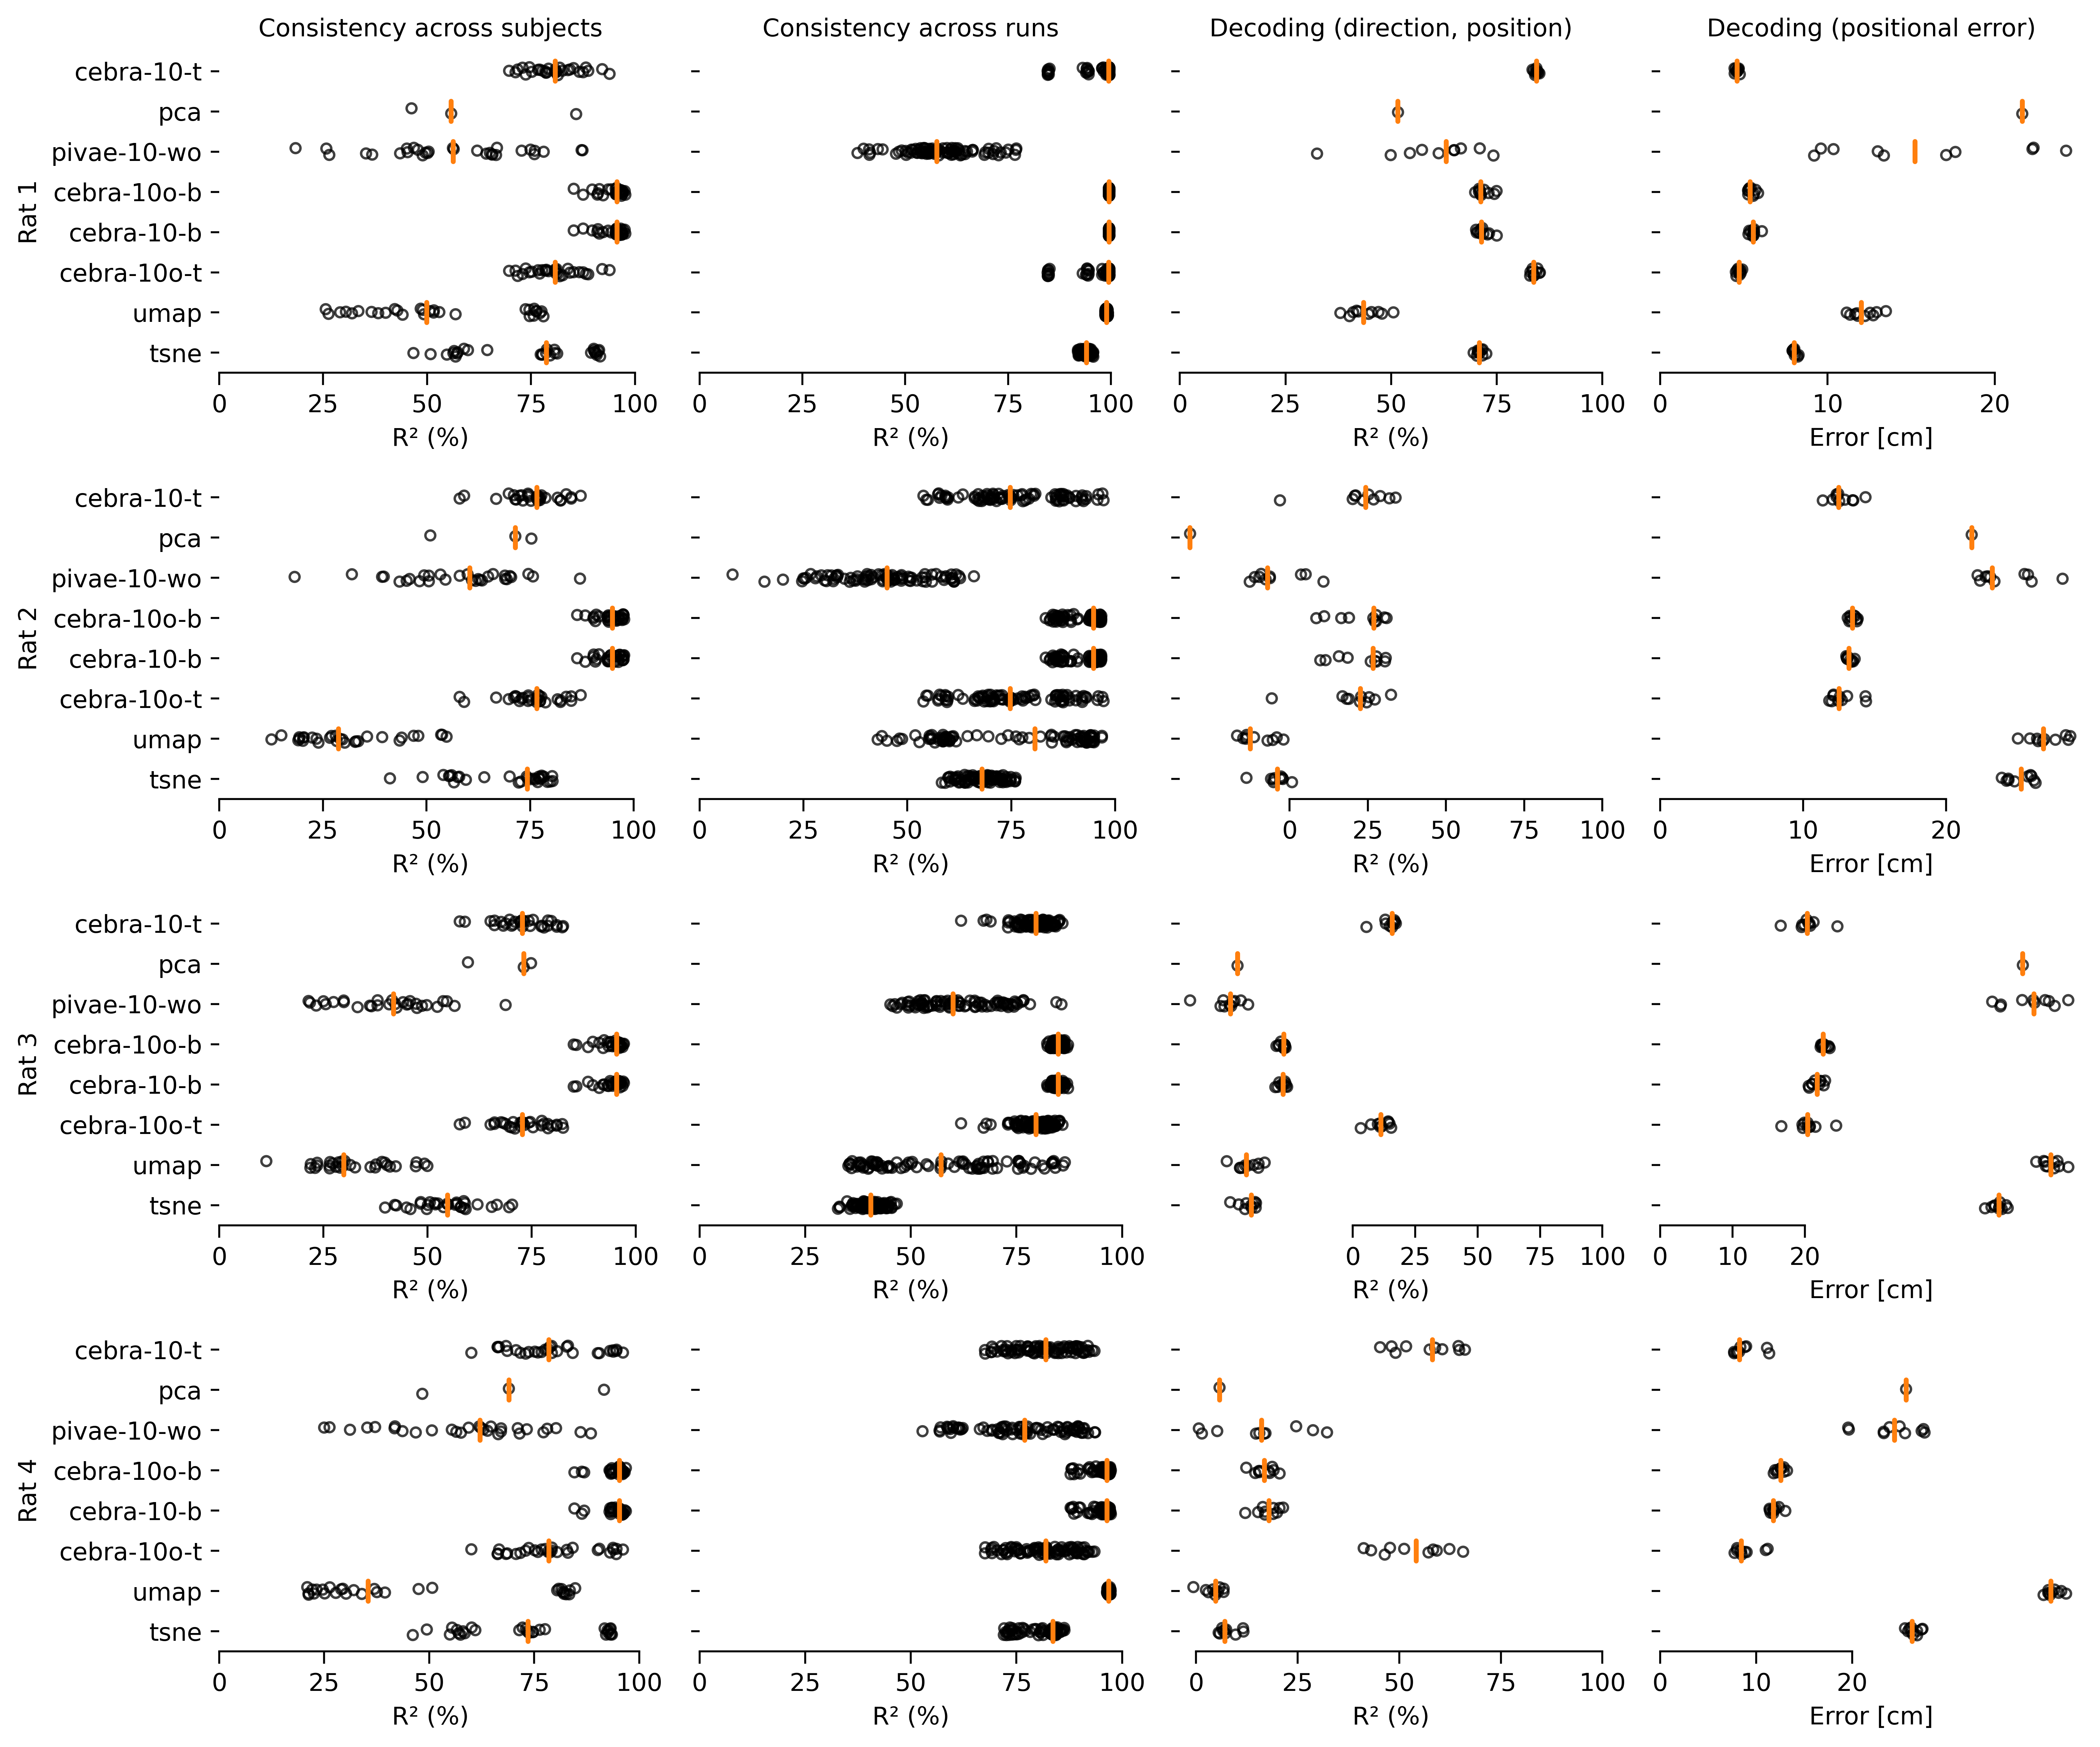

In [4]:
def plot_boxplots(results_best):
    metadata = [
        ("train", "Consistency across subjects", 100, "R² (%)", [0, 25, 50, 75, 100]),
        (
            "train_run_consistency",
            "Consistency across runs",
            100,
            "R² (%)",
            [0, 25, 50, 75, 100],
        ),
        (
            "test_total_r2",
            "Decoding (direction, position)",
            100,
            "R² (%)",
            [0, 25, 50, 75, 100],
        ),
        (
            "test_position_error",
            "Decoding (positional error)",
            100,
            "Error [cm]",
            [0, 10, 20],
        ),
    ]

    results_ = join(results_best)
    fig, axes = plt.subplots(4, 4, figsize=(12, 10), dpi=500, sharey=True)
    label_order = tuple(results_best.keys())

    for metric_id, (metric, metric_name, scale, xlabel, xlim) in enumerate(metadata):
        table = (
            results_.reset_index(drop=True)
            .pivot_table(
                metric,
                index=["animal", "repeat"],
                columns=["method"],
                aggfunc=list,
            )
            .applymap(
                lambda v: list(
                    itertools.chain.from_iterable(v)
                    if isinstance(v[0], typing.Iterable)
                    else v
                )
            )
            .groupby("animal", level=0)
            .agg(lambda v: np.stack(v).mean(0))
        )

        for animal in table.index:
            df = table.loc[animal].reset_index()
            df.columns = "method", "metric"
            df = df.explode("metric")
            df["metric"] *= scale

            show_boxplot(
                df=df, metric="metric", ax=axes[animal, metric_id], labels=label_order
            )
            ax = axes[animal, metric_id]
            ax.set_xlabel(xlabel)
            ax.set_xticks(xlim)
            ax.spines["bottom"].set_bounds(min(xlim), max(xlim))

            axes[0, metric_id].set_title(metric_name, fontsize=10)
            axes[animal, 0].set_ylabel(f"Rat {animal+1}")

    plt.tight_layout()


plot_boxplots(results)